In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%config Completer.use_jedi = False # 配置kaggle使用代码提示
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognition-data/sample_submission.csv
/kaggle/input/digit-recognition-data/digi-recog-train.csv
/kaggle/input/digit-recognition-data/digit-recog-test.csv


In [ ]:
!nvidia-smi

In [3]:
import torch

print(torch.cuda.is_available())

True


In [ ]:
!pip show sklearn

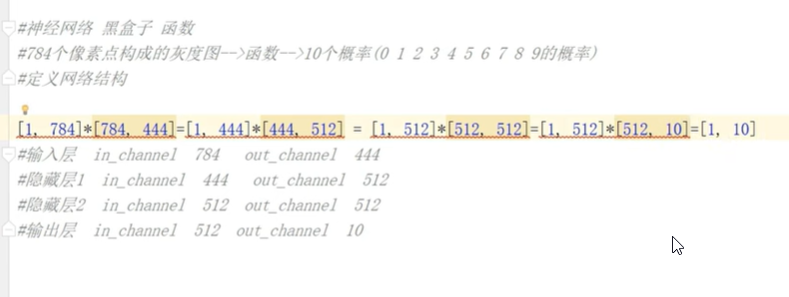

In [24]:

# 用代码搭建神经网络
import torch
import torch.nn as nn

# model = nn.Sequential(
#     nn.Linear(784,444),
#     nn.ReLU(), #使用ReLU函数作为激活函数
#     nn.Linear(444,512),
#     nn.ReLU(),
#     nn.Linear(512,512),
#     nn.ReLU(),
#     nn.Linear(512,10),
#     nn.Softmax()
# )

# # print(model)
# #GPU加速第一步,启用模型的cuda方法
# model = model.cuda() # 调用了这个函数后,模型的数据就会转存到显存里面

# 也可以这么写
model = nn.Sequential(
    nn.Linear(784,444),
    nn.ReLU(), #使用ReLU函数作为激活函数
    nn.Linear(444,512),
    nn.ReLU(),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,10),
    nn.Softmax()
).cuda()

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=444, bias=True)
  (1): ReLU()
  (2): Linear(in_features=444, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=10, bias=True)
  (7): Softmax(dim=None)
)


In [7]:
# 上面的模型的w和b是随机值不好用,我们需要对他进行训练,但是在训练之前,我们需要来验证一下这个模型是否合理,
# 也就是输入784个特征,是否能够达到10个概率
data = torch.rand(1,784)
pred = model(data)
print(pred) # 得到10个概率,说明我们的模型搭建合理


tensor([[0.1055, 0.0964, 0.1002, 0.0981, 0.0986, 0.1065, 0.1023, 0.0948, 0.0996,
         0.0981]], grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [8]:
# 加载数据并且进行整理,划分训练集和测试集

import pandas as pd

# 读取数据
data = pd.read_csv("/kaggle/input/digit-recognition-data/digi-recog-train.csv")
# data
# 整理数据划分标签和特征
#标签
label = data["label"].values
# label
#特征,需要获取特征,只需要把label这一列删除即可
data = data.drop(['label'],axis=1)
# data
feature = data.values
# 检查标签的长度和特征的长度是否一样
print(len(label),int(len(feature)))


42000 42000


In [25]:
# 划分训练集和测试集,使用切片就可以做到
train_feature = feature[:int(len(feature)*0.8)] # 注意,切片的结束标记必须是整数
train_label = label[:int(len(label)*0.8)] # 注意,切片的结束标记必须是整数

test_feature = feature[int(len(feature)*0.8):] # 注意,切片的结束标记必须是整数
test_label = label[int(len(label)*0.8):] # 注意,切片的结束标记必须是整数

# 需要把数据从numpy.ndarray转化为tensor类型
train_feature = torch.tensor(train_feature).to(torch.float).cuda()
train_label = torch.tensor(train_label).cuda()
test_feature = torch.tensor(test_feature).to(torch.float).cuda()
test_label = torch.tensor(test_label).cuda()
print(len(train_feature),len(train_label),len(test_feature),len(test_label))

33600 33600 8400 8400


In [28]:
# 训练模型
# 使用梯度下降来找到一组合适的w和b值使得损失越小越好
# 需要使用损失熵函数,这里使用交错损失函数
loss_fun = nn.CrossEntropyLoss()
# 确定使用什么样的优化器,一般使用Adam,需要传递你想优化的参数以及学习率(一般使用0.001或者0.0001)
optimizor = torch.optim.Adam(params=model.parameters(),lr=0.0001)
##  训练轮数,理论上讲,训练轮数越多,模型在训练集上面的表现就越好,这里我们先训练100轮
for i in range(100):
    # 训练步骤
    # 1)清空优化器的梯度(偏导
    optimizor.zero_grad()
    # 2)预测,也叫做前向传播
    pred = model(train_feature)
    # 计算准确率
    # 首先需要获取每一行的最大值对应的索引             
    result = torch.argmax(pred,axis=1)  
    # print(result)   
    # 计算准确率
    train_acc = torch.mean((result == train_label).to(torch.float))
    
    # 3)计算损失值
    loss =loss_fun(pred,train_label)
    # 4)反向传播
    loss.backward()
    # 5)进行梯度下降操作,在优化器里面做
    optimizor.step()
    # 查看每一轮的损失值和准确率
    print(f"train loss:{loss.item()},train_acc:{train_acc}")
    #在测试集上面的表现
    # 1)清空优化器的梯度(偏导
    optimizor.zero_grad()
    # 2)预测,也叫做前向传播
    pred = model(test_feature)
     # 计算准确率
    # 首先需要获取每一行的最大值对应的索引             
    result = torch.argmax(pred,axis=1)  
    # 计算准确率
    test_acc = torch.mean((result == test_label).to(torch.float))
     # 3)计算损失值
    loss =loss_fun(pred,test_label) 
    # 注意,在使用测试集的时候就不需要梯度下降了,因为他是用来训练模型的.
     # 查看每一轮的损失值和准确率
    print(f"test loss:{loss.item()},test_acc:{test_acc}")
    # print()
#保存模型
torch.save(model.state_dict(),'./mymodel.pt')

train loss:2.3546297550201416,train_acc:0.06955356895923615
test loss:2.253931760787964,test_acc:0.18440476059913635
train loss:2.255866765975952,train_acc:0.17898809909820557
test loss:2.162668228149414,test_acc:0.3063095211982727
train loss:2.165099620819092,train_acc:0.30413690209388733
test loss:2.086108446121216,test_acc:0.39226189255714417
train loss:2.0899977684020996,train_acc:0.3861309587955475
test loss:2.0310168266296387,test_acc:0.4389285743236542
train loss:2.036078453063965,train_acc:0.4317261874675751
test loss:1.980543851852417,test_acc:0.4888095259666443
train loss:1.9859856367111206,train_acc:0.48249998688697815
test loss:1.9306292533874512,test_acc:0.5395237803459167
train loss:1.9345576763153076,train_acc:0.5355952382087708
test loss:1.8851879835128784,test_acc:0.5897619128227234
train loss:1.8879897594451904,train_acc:0.5873512029647827
test loss:1.860435962677002,test_acc:0.6194047331809998
train loss:1.8621022701263428,train_acc:0.6135416626930237
test loss:1.844

In [21]:
#加载模型,注意此时不需要再训练或者保存模型(如果在同一个cell里面,需要把训练模型的代码注释起来,使用不同的cell就不需要注释)
# 因为上面已经把模型训练好了并且保持下来了,所以我们可以直接加载使用
#加载模型文件里面的参数也就是w和b
params = torch.load("./mymodel.pt")
# 把参数放入模型里面
model.load_state_dict(params)

# 我们从测试集里面挑取一些数据
new_test_data = test_feature[100:111]
new_test_label = test_label[100:111]

pred = model(new_test_data)
# 计算准确率
# 首先需要获取每一行的最大值对应的索引             
result = torch.argmax(pred,axis=1)  
print(result,new_test_label)

tensor([5, 1, 8, 9, 6, 2, 7, 9, 6, 3, 6]) tensor([5, 1, 8, 3, 6, 2, 7, 9, 6, 3, 6])


## 使用GPU进行加速
虽然我们安装了GPU和cuda,但是他默认是不会使用的,需要我们手动来使用
#### 首先需要保证你安装了GPU版本的torch并且安装了cuda

需要回到上面的创建模型的代码,在模型常见后,调用模型的cuda方法

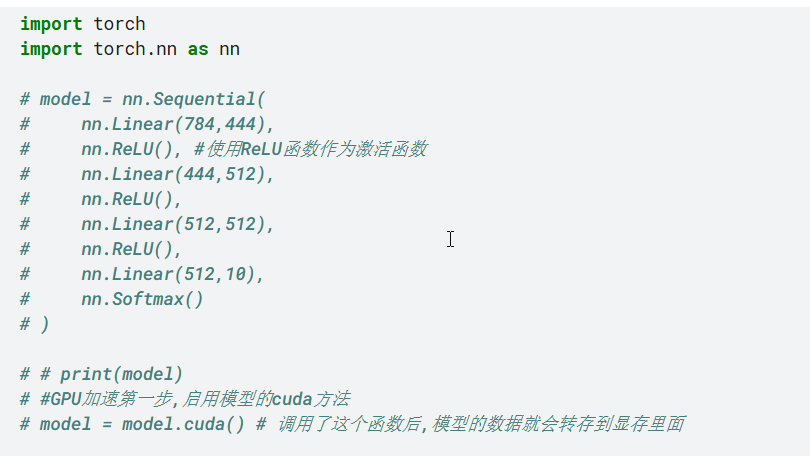
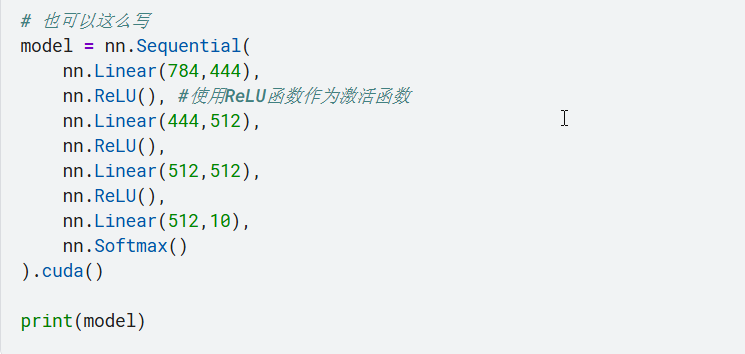

## 然后把训练集和测试集的数据都输送到显存里面
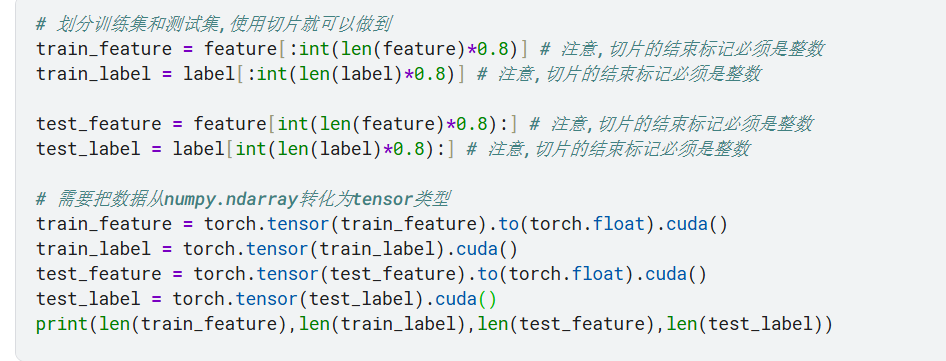

## 然后,我们可以把训练模式的代码运行一次,发现速度快很多